In [27]:
import math
import sys
import json
import argparse
import pandas as pd
import numpy as np
import scipy.signal as signal
from sklearn import decomposition, preprocessing  
from mpl_toolkits.mplot3d import Axes3D  
import cv2
import matplotlib.pyplot as plt
from numba import jit
import plotly.express as px


### gaussian smoothing
import scipy
from scipy.ndimage import gaussian_filter1d

### Utilities

In [58]:
def gaussian_smooth(time_series, sig = 1, axis = -1):
    smooth_time_series = scipy.ndimage.gaussian_filter1d(time_series, sigma = sig, axis = axis)
    return smooth_time_series

In [41]:
df = pd.read_csv('../../dataset/CSI_DATA/outdoor/spot2.csv')
print(df.columns)

Index(['type', 'role', 'mac', 'rssi', 'rate', 'sig_mode', 'mcs', 'bandwidth',
       'smoothing', 'not_sounding', 'aggregation', 'stbc', 'fec_coding', 'sgi',
       'noise_floor', 'ampdu_cnt', 'channel', 'secondary_channel',
       'local_timestamp', 'ant', 'sig_len', 'rx_state', 'real_time_set',
       'real_timestamp', 'len', 'CSI_DATA'],
      dtype='object')


### RSSI

Text(0, 0.5, 'rssi magnitude')

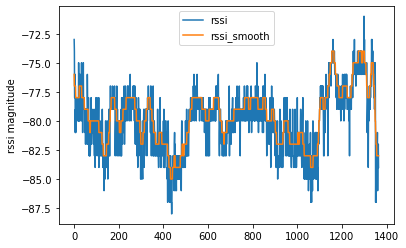

In [42]:
df_rssi = df.loc[:,['real_timestamp','rssi']]
df_rssi['rssi_smooth'] = gaussian_smooth(df_rssi['rssi'], sig = 5)
df_rssi.plot(y =['rssi', 'rssi_smooth'] )
plt.ylabel('rssi magnitude')

### CSI

In [65]:
def load_csi(filepath):
    df = pd.read_csv(filepath)

    df_csi = df.loc[:, ['len','real_timestamp' 'CSI_DATA']]
    drop_idx = []
    real_time = []
    for i in range(df_csi.shape[0]):
        if df_csi.iloc[i]['len'] < 384:
            drop_idx.append(i)
            real_time.append(df_csi.iloc[i]['real_timestamp'])

    df_csi = df_csi.drop(drop_idx)
    size_x = len(df_csi.index)
    size_y = df_csi.iloc[0]['len']//2 # no. of subcarriers ..

    array_csi = np.zeros([size_x, size_y], dtype = np.complex64)

    for x , csi in enumerate(df_csi.iloc):
        temp = csi["CSI_DATA"].replace(' ', ',')
        temp = temp.replace(',]', ']')
        csi_raw_data = json.loads(temp)
        for y in range(0, len(csi_raw_data), 2):
            array_csi[x][y//2] = complex(csi_raw_data[y], csi_raw_data[y + 1])  # IQ channel frequency response
    array_csi_modulus = abs(array_csi) 
    
    return array_csi_modulus, real_time

def plot_csi(array_csi_modulus):
    df = pd.DataFrame(array_csi_modulus[300:-300], columns=range(array_csi_modulus.shape[1]))
    fig = px.line(df, y = list(range(array_csi_modulus.shape[1])),title="CSI Magnitude")
    fig.show()
    


In [66]:

#### Plotting the mean magnitude..
array_csi_modulus, real_time = load_csi('../../dataset/CSI_DATA/outdoor/spot2.csv')

df = pd.DataFrame()
df["LLTF"] = np.mean(array_csi_modulus[:,:64], axis=0)
df["HT-LTF"] = np.mean(array_csi_modulus[:,64:128], axis=0)
df["STBC-HT-LTF"] = np.mean(array_csi_modulus[:,128:], axis=0)
fig = px.line(df, title="Magnitude Mean vs Subcarrier")
fig.show()

KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

ValueError: x and y must have same first dimension, but have shapes (1365,) and (1167,)

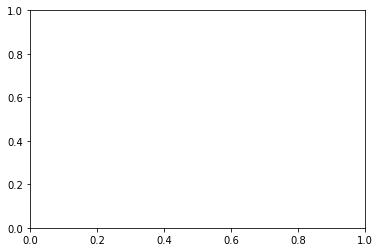

In [64]:
csi_mod_smooth = gaussian_smooth(array_csi_modulus, sig = 4, axis = 1)
lltf_csi = array_csi_modulus[:,:64]
ht_ltf = array_csi_modulus[:,64:128]
stbc_ht_ltf = array_csi_modulus[:,128:]


for i in range(lltf_csi.shape[1]):
    plt.plot(df_rssi['real_timestamp'], lltf_csi[:,i])
    
plt.show()

In [45]:
time_0 = df_time.iloc[0]['real_timestamp']
time_n = df_time.iloc[-1]['real_timestamp']
print('Duration of this experiment %.2f(in secs)'%time_n)

Duration of this experiment 30.44(in secs)
